# Image Segmentation

## Setup

In [1]:
import os
import re

import numpy as np
import matplotlib.pyplot as plt
from icecream import ic

from PIL import Image

import tensorflow as tf

from sklearn.model_selection import train_test_split

## Dataset

In [2]:
dataset_path = "../datasets/camseq-semantic-segmentation/"
filenames = os.listdir(dataset_path)
filenames.sort()

image_list = []
masks_list = []

for filename in filenames:
    if filename.endswith(".png"):
        if filename.split(".")[0][-2:] == "_L":
            masks_list.append(dataset_path + filename)
        else:
            image_list.append(dataset_path + filename)

In [3]:
train_img_paths, val_img_paths, train_masks_path, val_masks_path = train_test_split(image_list, masks_list, test_size=0.2, random_state=1992)

In [4]:
def load_data(images_path: list, masks_path: list) -> None:
    samples = {"images": [], "masks": []}

    for i in range(len(images_path)):
        img = Image.open(images_path[i])
        mask = Image.open(masks_path[i])
        img = img.resize((256, 256), Image.NEAREST)
        mask = mask.resize((256, 256), Image.NEAREST)

        samples["images"].append(np.array(img))
        samples["masks"].append(np.array(mask))

    samples = {
        "images": np.array(samples["images"]) / 255.0,
        "masks": np.array(samples["masks"]) / 255.0,
    }

    return samples

In [5]:
train_ds = load_data(train_img_paths, train_masks_path)
valid_ds = load_data(val_img_paths, val_masks_path)

In [6]:
train_ds["masks"]

array([[[[0.50196078, 0.        , 0.        ],
         [0.50196078, 0.        , 0.        ],
         [0.50196078, 0.        , 0.        ],
         ...,
         [0.50196078, 0.50196078, 0.        ],
         [0.50196078, 0.50196078, 0.        ],
         [0.50196078, 0.50196078, 0.        ]],

        [[0.50196078, 0.        , 0.        ],
         [0.50196078, 0.        , 0.        ],
         [0.50196078, 0.        , 0.        ],
         ...,
         [0.50196078, 0.50196078, 0.        ],
         [0.50196078, 0.50196078, 0.        ],
         [0.50196078, 0.50196078, 0.        ]],

        [[0.50196078, 0.        , 0.        ],
         [0.50196078, 0.        , 0.        ],
         [0.50196078, 0.        , 0.        ],
         ...,
         [0.50196078, 0.50196078, 0.        ],
         [0.50196078, 0.50196078, 0.        ],
         [0.50196078, 0.50196078, 0.        ]],

        ...,

        [[0.        , 0.        , 0.75294118],
         [0.        , 0.        , 0.75294118]

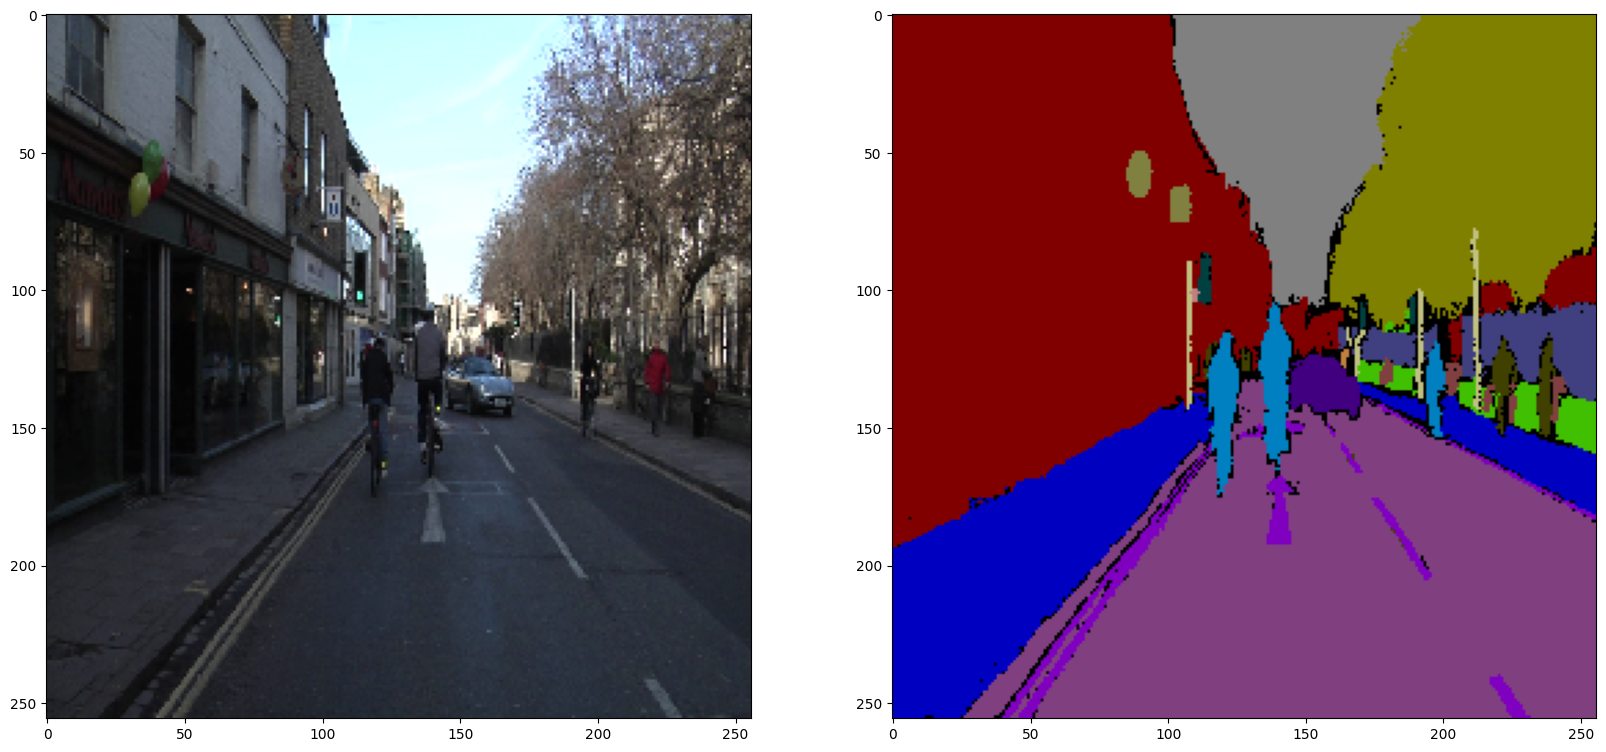

In [7]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(train_ds["images"][10])
plt.subplot(1, 2, 2)
plt.imshow(train_ds["masks"][10])
plt.show()

## Fine-Tuning U-Net

In [8]:
def create_conv_block(input_tensor: tf.Tensor, num_filters: int) -> tf.Tensor:
    x = tf.keras.layers.Conv2D(
        filters=num_filters,
        kernel_size=(3, 3),
        kernel_initializer="he_normal",
        padding="same",
    )(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("gelu")(x)

    x = tf.keras.layers.Conv2D(
        filters=num_filters,
        kernel_size=(3, 3),
        kernel_initializer="he_normal",
        padding="same",
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("gelu")(x)

    return x


def create_u_net(input_shape: tf.Tensor, num_filters: int =16, dropout: float =0.1) -> tf.keras.Model:

    # Encoder 
    c1 = create_conv_block(input_shape, num_filters)
    p1 = tf.keras.layers.MaxPool2D((2, 2))(c1)
    p1 = tf.keras.layers.Dropout(dropout)(p1)

    c2 = create_conv_block(p1, num_filters * 2)
    p2 = tf.keras.layers.MaxPool2D((2, 2))(c2)
    p2 = tf.keras.layers.Dropout(dropout)(p2)

    c3 = create_conv_block(p2, num_filters * 4)
    p3 = tf.keras.layers.MaxPool2D((2, 2))(c3)
    p3 = tf.keras.layers.Dropout(dropout)(p3)
    
    c4 = create_conv_block(p3, num_filters * 8)
    p4 = tf.keras.layers.MaxPool2D((2, 2))(c4)
    p4 = tf.keras.layers.Dropout(dropout)(p4)

    c5 = create_conv_block(p4, num_filters * 16)
    p5 = tf.keras.layers.MaxPool2D((2, 2))(c5)
    p5 = tf.keras.layers.Dropout(dropout)(p5)

    # Decoder
    u6 = tf.keras.layers.Conv2DTranspose(num_filters * 8, (3, 3), strides=(2, 2), padding="same")(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(dropout)(u6)
    c6 = create_conv_block(u6, num_filters * 8)

    u7 = tf.keras.layers.Conv2DTranspose(num_filters * 4, (3, 3), strides=(2, 2), padding="same")(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(dropout)(u7)
    c7 = create_conv_block(u7, num_filters * 4)

    u8 = tf.keras.layers.Conv2DTranspose(num_filters * 2, (3, 3), strides=(2, 2), padding="same")(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(dropout)(u8)
    c8 = create_conv_block(u8, num_filters * 2)

    u9 = tf.keras.layers.Conv2DTranspose(num_filters, (3, 3), strides=(2, 2), padding="same")(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(dropout)(u9)
    c9 = create_conv_block(u9, num_filters)

    output = tf.keras.layers.Conv2D(3, (1, 1), activation="sigmoid")(c9)
    model = tf.keras.Model(inputs=[input_shape], outputs=[output])

    return model


In [9]:
inputs = tf.keras.layers.Input((256, 256, 3))
model = create_u_net(inputs)

In [10]:
model.compile(
    optimizer="Adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
model_history = model.fit(
    train_ds["images"],
    train_ds["masks"],
    batch_size=8,
    epochs=200
)

Epoch 1/200
10/10 [==============================] - 25s 213ms/step - loss: 0.6960 - accuracy: 0.3058
Epoch 2/200
10/10 [==============================] - 2s 207ms/step - loss: 0.6177 - accuracy: 0.4523
Epoch 3/200
10/10 [==============================] - 2s 206ms/step - loss: 0.5780 - accuracy: 0.5397
Epoch 4/200
10/10 [==============================] - 2s 207ms/step - loss: 0.5588 - accuracy: 0.5251
Epoch 5/200
10/10 [==============================] - 2s 206ms/step - loss: 0.5473 - accuracy: 0.4834
Epoch 6/200
10/10 [==============================] - 2s 207ms/step - loss: 0.5379 - accuracy: 0.4881
Epoch 7/200
10/10 [==============================] - 2s 206ms/step - loss: 0.5276 - accuracy: 0.4714
Epoch 8/200
10/10 [==============================] - 2s 206ms/step - loss: 0.5180 - accuracy: 0.4718
Epoch 9/200
10/10 [==============================] - 2s 207ms/step - loss: 0.5109 - accuracy: 0.4748
Epoch 10/200
10/10 [==============================] - 2s 206ms/step - loss: 0.5059 - accur

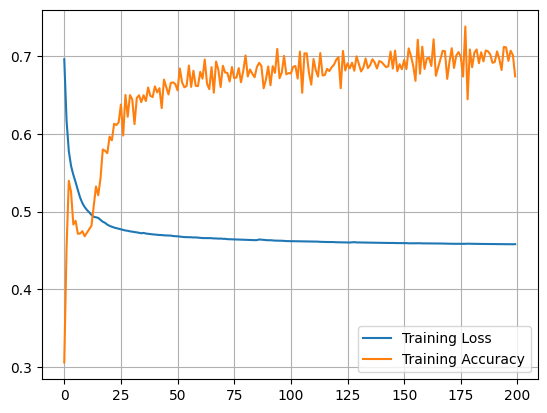

In [13]:
plt.plot(model_history.history["loss"], label="Training Loss")
plt.plot(model_history.history["accuracy"], label="Training Accuracy")
plt.legend()
plt.grid(True)

In [16]:
def predict_test_samples(val_map, model):
    img = val_map["images"]
    mask = val_map["masks"]

    test_images = np.array(img)
    predictions = model.predict(test_images)
    return predictions, test_images, mask

def plot_images(test_image, predicted_mask, ground_truth_mask):
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 3, 1)
    plt.imshow(test_image)
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask)
    plt.title("Predicted Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth_mask)
    plt.title("Ground Truth Mask")

In [17]:
predicted_masks, test_images, ground_truth_masks = predict_test_samples(valid_ds, model)

1/1 [==============================] - 5s 5s/step


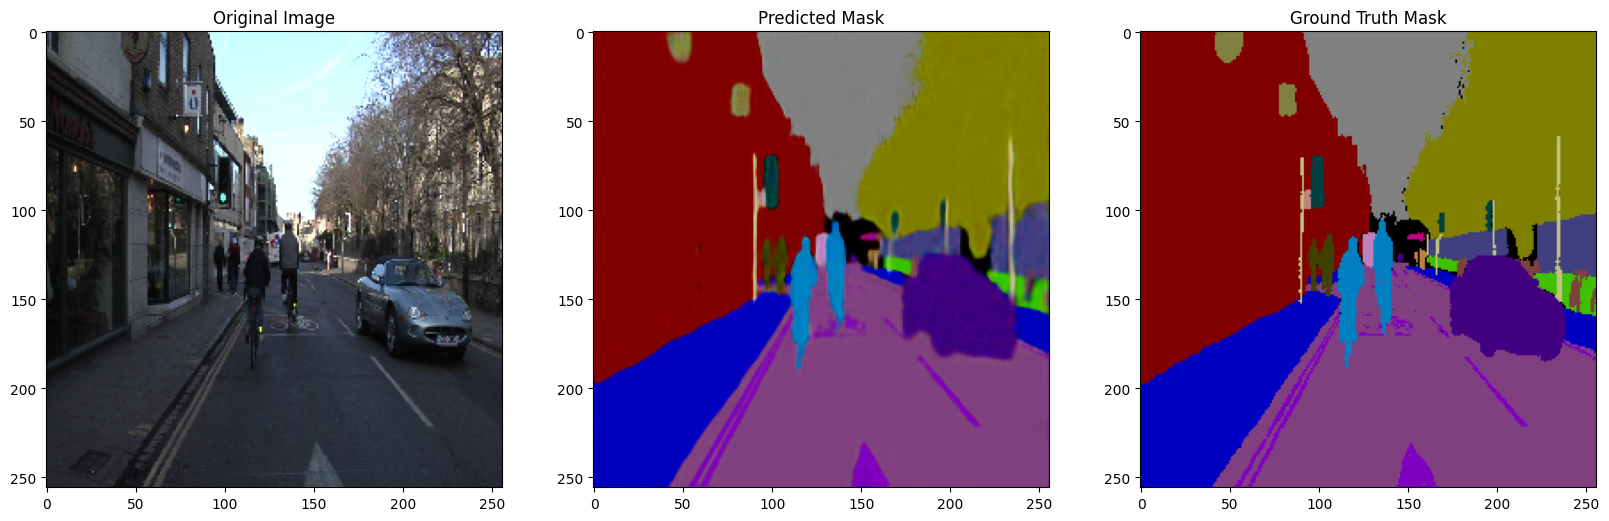

In [20]:
plot_images(test_images[15], predicted_masks[15], ground_truth_masks[15])